Description: solutions to Case Study 5

Version: 1.2.3.20210401

Author: Haodong Liu and Jichen Zhao

Last editors: Haodong Liu

# Case Study 5

This case study explores various options for model selection on a clustering task.

**The task** involves comparing multiple model selection metrics on a Gaussian mixture model (GMM) using the digits dataset projected into the 2D principal component analysis (PCA) space.

**The objective measure** is to use visualisation to evaluate the models selected with metrics by observing which digits are being grouped or split.

## 1. Importing Modules

This case study is accomplished in the context of using [`scikit-learn`](https://scikit-learn.org/stable/) as a tool to explore relevant techniques.

**NOTE: It has been found and validated that different versions of scikit-learn can produce different results in some parts even with the same code. Please use the version 0.24.1 to get the same results.**

In [1]:
# NOTE: Uncomment the following line to force installing scikit-learn 0.24.1.
#!pip install -U --force-reinstall --no-cache --no-warn-script-location --user scikit-learn==0.24.1

In [2]:
import warnings

from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Ellipse
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
import numpy as np


warnings.filterwarnings('ignore', category = UserWarning)

## 2. Loading Data

The [`load_digits()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) function is used to load the digits dataset. The [`scale()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) function standardises the data.

In [3]:
X, y = load_digits(return_X_y = True)
X = scale(X)
n_digits = len(np.unique(y))
print('Number of digits:', n_digits)
print('Number of samples:', len(y))  # Equal to "X.shape[0]".
print('Number of features:', X.shape[1])

Number of digits: 10
Number of samples: 1797
Number of features: 64


As per the task specification, the data is projected into 2D using the [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to perform PCA to keep 2 principal components (PC).

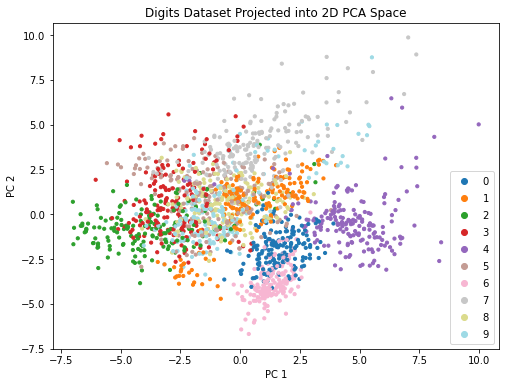

In [4]:
X_pca = PCA(2).fit_transform(X)

# Plot the projected data.
plt.figure(figsize = (8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'tab20', s = 10)
plt.title('Digits Dataset Projected into 2D PCA Space')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(*scatter.legend_elements())
plt.show()

## 3. Model Selection

Ideally, the number of mixture components `k` equals `n_digits` (i.e., 10) as per the data. Here the range of `k` is set to `n_digits ± 5`. A covariance matrix type representation is selected from the list `['diag', 'full', 'spherical', 'tied']`. 4 model selection metrics are applied to select the optimal `k` and the covariance matrix type preferred by each metric. These metrics include the Bayesian information criterion (BIC), Akaike information criterion (AIC), silhouette score, and cross-validation (CV). The [`GuassianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) class is used to build a GMM. The [`silhouette_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) function can help to compute the silhouette. The [`KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class is used to perform 6-fold CV. The CV results are in the form of log-likelihood on hold-out observations. The [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function can help to compute the CV log-likelihood.

In [5]:
ks = np.arange(n_digits - 5, n_digits + 6)  # The range of k to select
cov_types = ['diag', 'full', 'spherical', 'tied']
metrics = ['BIC', 'AIC', 'Silhouette score', 'CV log-likelihood']  # Representations of the 4 model selection metrics.
gmms = []  # A list storing each covariance matrix type's GMMs.
scores = {metrics[0]: [], metrics[1]: [], metrics[2]: [], metrics[3]: []}  # A dictionary storing each metric's scores.
best_params = {}  # A dictionary storing the optimal k and the covariance matrix type preferred by each metric. Each key's value is a list like [k, cov_type].

for i, cov_type in enumerate(cov_types):
    gmms.append([GaussianMixture(k, covariance_type = cov_type, random_state = 0).fit(X_pca) for k in ks])
    scores[metrics[0]].append([gmm.bic(X_pca) for gmm in gmms[i]])  # Compute BIC.
    scores[metrics[1]].append([gmm.aic(X_pca) for gmm in gmms[i]])  # Compute AIC.
    scores[metrics[2]].append([silhouette_score(X_pca, gmm.predict(X_pca)) for gmm in gmms[i]])  # Compute the silhouette score.
    scores[metrics[3]].append([np.mean(cross_val_score(gmm, X_pca, y, cv = KFold(6))) for gmm in gmms[i]])  # Compute the CV log-likelihood.

  A function is defined to reuse code.

In [6]:
def select_best_params(metric: str = metrics[0]) -> None:
    '''
    Select the optimal k and the covariance matrix type preferred by a specified metric.

    Parameters
    ----------
    metric : one of the metric in the metric list
    '''

    best_ks = []
    best_scores = []
    xticks_locs = np.arange(len(ks))
    plt.figure(figsize = (8, 4))

    for i, cov_type in enumerate(cov_types):
        scores_metric = scores[metric][i]
        best_score_index = np.argmax(scores_metric) if metric == metrics[2] or metric == metrics[3] else np.argmin(scores_metric)  # The higher silhouette score or CV log-likelihood, the better. Otherwise, the lower, the better.
        best_ks.append(ks[best_score_index])
        best_scores.append(scores_metric[best_score_index])
        plt.bar(xticks_locs + 0.2 * i - 0.3, scores_metric, label = cov_type, width = 0.2)  # Plot bars indicating this covariance matrix type's scores.
    
    plt.title(metric + ' Per Model')
    plt.xlabel('K')
    plt.xticks(xticks_locs, ks)
    plt.ylabel(metric)
    adjustment = 0.01 if metric == metrics[2] or metric == metrics[3] else 10
    plt.ylim(np.min(scores[metric]) - adjustment, np.max(scores[metric]) + adjustment)  # Narrow down y-axis limits properly to make the chart look better.
    plt.legend(bbox_to_anchor = (1.2, 0.5), loc = 'right')
    plt.show()
    best_score_index = np.argmax(best_scores) if metric == metrics[2] or metric == metrics[3] else np.argmin(best_scores)  # The higher silhouette score or CV log-likelihood, the better. Otherwise, the lower, the better.
    best_params[metric] = [best_ks[best_score_index], cov_types[best_score_index]]
    print('Best parameters:', best_params[metric])  # Print the best parameters like [k, cov_type].

Score results are returned respectively for the 4 model selection metrics.

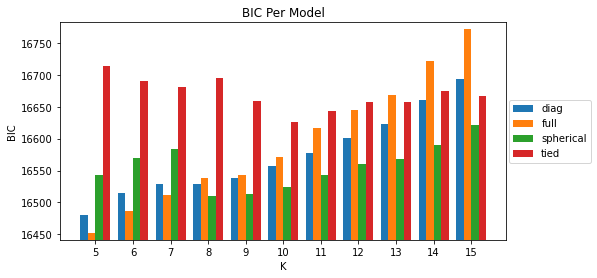

Best parameters: [5, 'full']


In [7]:
select_best_params()  # Use my function to select the optimal k and the covariance matrix type preferred by BIC.

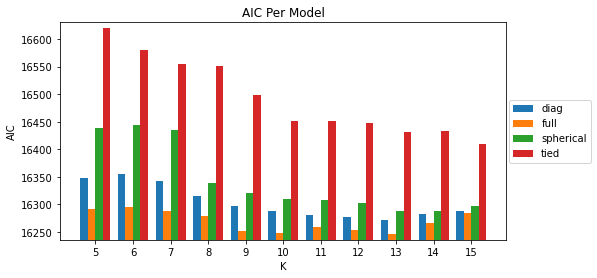

Best parameters: [13, 'full']


In [8]:
select_best_params(metrics[1])  # Use my function to select the optimal k and the covariance matrix type preferred by AIC.

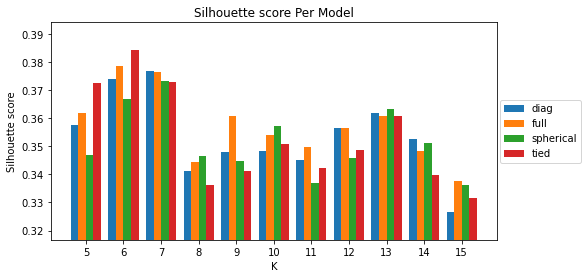

Best parameters: [6, 'tied']


In [9]:
select_best_params(metrics[2])  # Use my function to select the optimal k and the covariance matrix type preferred by the silhouette.

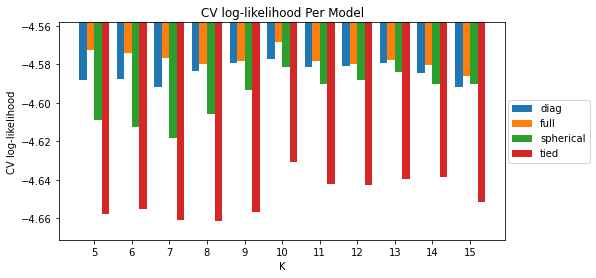

Best parameters: [10, 'full']


In [10]:
select_best_params(metrics[3])  # Use my function to select the optimal k and the covariance matrix type preferred by CV.

## 4. Evaluation

The best parameters suggested by each metric are evaluated by visualising the Gaussian mixture components and covariance ellipses. A function is defined to reuse code.

In [11]:
gmms_best = [GaussianMixture(best_params[metric][0], covariance_type = best_params[metric][1]).fit(X_pca) for metric in metrics]
colours = get_cmap('tab20_r').colors


def plot_components(gmm: GaussianMixture) -> None:
    '''
    Plot the Gaussian mixture components and covariance ellipses.

    Parameters
    ----------
    gmm : a fitted GMM
    '''

    plt.figure(figsize = (8, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c = gmm.predict(X_pca), cmap = 'tab20', s = 10)
    ax = plt.gca()

    for i, colour in enumerate(colours[:gmm.get_params()['n_components']]):
        if gmm.covariance_type == cov_types[0]:  # 'diag'
            cov = np.diag(gmm.covariances_[i][:2])
        
        if gmm.covariance_type == cov_types[1]:  # 'full'
            cov = gmm.covariances_[i][:2, :2]
        
        if gmm.covariance_type == cov_types[2]:  # 'spherical'
            cov = np.eye(gmm.means_.shape[1]) * gmm.covariances_[i]

        if gmm.covariance_type == cov_types[3]:  # 'tied'
            cov = gmm.covariances_[:2, :2]
        
        v, w = np.linalg.eigh(cov)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # Convert to degrees.
        v = 2 * np.sqrt(2) * np.sqrt(v)
        ell = Ellipse(gmm.means_[i, :2], v[0], v[1], 180 + angle, color = colour)  # Draw a covariance ellipse.
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.7)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    
    plt.legend(*scatter.legend_elements())

Visualisation is done respectively for the 4 model selection metrics.

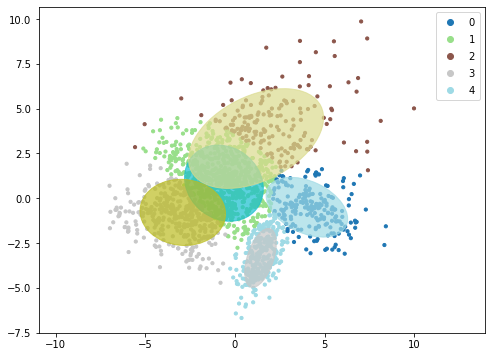

In [12]:
plot_components(gmms_best[0])  # Use my function to plot the Gaussian mixture components and covariance ellipses for BIC.

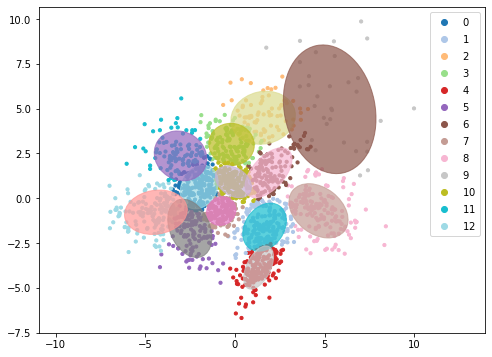

In [13]:
plot_components(gmms_best[1])  # Use my function to plot the Gaussian mixture components and covariance ellipses for AIC.

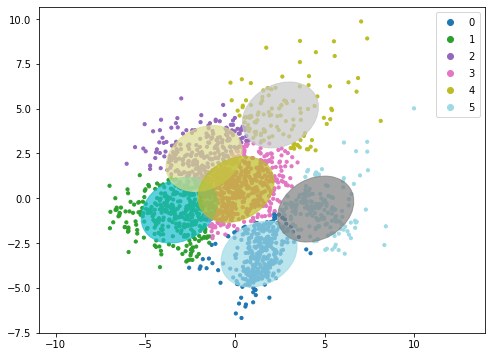

In [14]:
plot_components(gmms_best[2])  # Use my function to plot the Gaussian mixture components and covariance ellipses for the silhouette score.

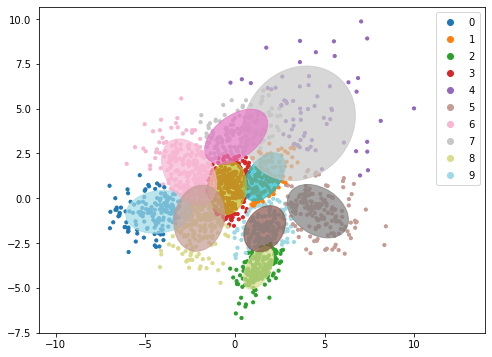

In [15]:
plot_components(gmms_best[3])  # Use my function to plot the Gaussian mixture components and covariance ellipses for CV.

For more info, please refer to the corresponding report.